In [19]:
from sklearn.neighbors import KNeighborsClassifier as kNC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

import numpy as np

# import dataset packages
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

# import from project files
from utils import plot_2d, plot_classifier_boundary, test_model
from plots import plot_test_training_err, plot_test_training_auc
from evaluation import dt_classifier_auc, dt_classifier_score, knn_classifier_err, knn_classifier_auc

## Dataset Generation ## 

### kNN ###
General: 
- Bla


Advantages:
- Easy to implement for multiclass problems


Disadvantages:
- KNN is very sensitive to outliers
- Dimensionality: KNN is more appropriate to use when you have a small number of inputs.
- Class imbalance can be an issue: kNN might wrongly vote for majority class
- Sample size needs to be large enough and dense enough


### Decision Trees ###
General: 
- The key idea is to use a decision tree to partition the data space into dense regions and sparse regions.


Advantages:
- Good with High Level Data: e.g. age, income
- Cases of missing values and outliers have less significance on the decision tree’s data.


Disadvantages:
- Bad with Low Level Data: data with many predictors/inputs
- Trees can overfit: Overfitting increases with depth of tree

In [20]:
def data_nn():

    nn_X, nn_y = make_blobs(
        n_samples=1500,
        n_features=2,
        centers=220,
        cluster_std=.16,
        random_state=42
    )
    nn_y = nn_y % 2 # to reduce the amount of different labels to 2

    # kNN score - 0.92
    # DT score - 0.86
    # nn_X, nn_y = make_blobs(
    #     n_samples=1500,
    #     n_features=2,
    #     centers=220,
    #     cluster_std=.16,
    #     random_state=42
    # )
    # nn_y = nn_y % 2 # to reduce the amount of different labels to 2

    # nn_X, nn_y = make_blobs(
    #     n_samples=[250, 250], 
    #     centers=[(3,5),(6,5)],             
    #     n_features=2, 
    #     cluster_std=[1, 1],
    #     random_state=42, 
    #     shuffle=False)

    # nn_X, nn_y = make_moons(
    #     n_samples=[250, 250], 
    #     noise=0.5)

    return nn_X, nn_y

In [21]:
def data_dt():

    # kNN score - 0.78 (k = 12) 0.70 (k = 3)
    # DT score - 0.63
    # dt_X, dt_y = make_blobs(
    #     n_samples=[700, 200], 
    #     centers=[(3,5),(6,5)],             
    #     n_features=2, 
    #     cluster_std=[5, 4],
    #     random_state=1, 
    #     shuffle=False)

    # kNN score - 0.86 (12)
    # DT score - 0.88 (15, 10)
    # dt_X, dt_y = make_blobs(
    #     n_samples=[200, 200], 
    #     centers=[(3,5),(6,5)],             
    #     n_features=4, 
    #     # cluster_std=[2, 1],
    #     random_state=1, 
    #     shuffle=False)

    # knn 0.91
    # dt 0.95
    dt_X, dt_y = make_blobs(
        n_samples=[250, 50], 
        centers=[(3,5),(6,5)],             
        n_features=2, 
        cluster_std=[3, 1],
        random_state=42, 
        shuffle=False)


    # dt_X, dt_y = make_blobs(
    #     n_samples=[250, 250], 
    #     # centers=[(3,5),(6,5)],             
    #     n_features=4, 
    #     cluster_std=[3, 1],
    #     random_state=42, 
    #     )

    # dt_X, dt_y = make_circles(
    #     noise=0.2, 
    #     factor=0.5, 
    #     random_state=1)

    # dt_X, dt_y = make_blobs(
    #     n_samples=[300, 200], 
    #     centers=[(3,5),(6,5)],             
    #     n_features=2, 
    #     # cluster_std=[5, 4],
    #     random_state=1, 
    #     shuffle=False)

    # knn - 0.89 
    # dt - 0.89
    # dt_X, dt_y = m'ake_moons(
    #     n_samples=[200, 200], 
    #     noise=0.3)'

    return dt_X, dt_y

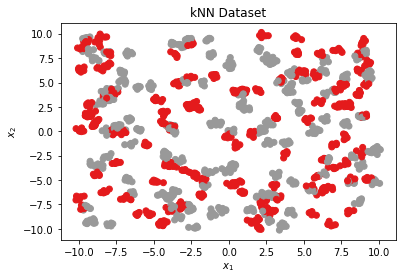

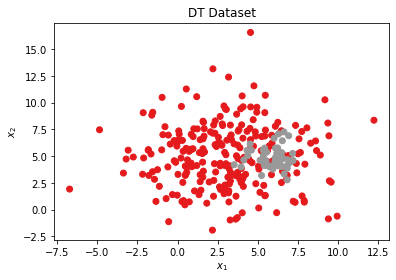

In [22]:
# kNN data generation and splitup
nn_X, nn_y = data_nn()
plot_2d(nn_X, nn_y, 'kNN Dataset')
nn_X_train, nn_X_test, nn_y_train, nn_y_test = train_test_split(nn_X, nn_y, test_size=.33, random_state=42)

# Decision Tree data generation and splitup
dt_X, dt_y = data_dt()
plot_2d(dt_X, dt_y, 'DT Dataset')
dt_X_train, dt_X_test, dt_y_train, dt_y_test = train_test_split(dt_X, dt_y, test_size=.33, random_state=42)


## Evaluation and Plotting Methods ##

In [23]:
#  Underfitting – Validation and training error high
#  Overfitting – Validation error is high, training error low
#  Good fit – Validation error low, slightly higher than the training error
#  Unknown fit - Validation error low, training error 'high'


## Hyperparameters ##

In [24]:
# Hyperparameters

# kNN
k_nn = 3 
k_dt = 5
k_values = np.arange(1, 30, 2)

# DT
criterion = 'entropy'
# min_samples_split best between [2, 40] (see https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680)
# if value too small trees tend to overfit
# Imbalanced class problem: because then regions in which the minority class will be in majority 
# will be very small so min_samples_split should be lower
min_samples_split_nn = 6
min_samples_split_dt = 4
nsamples = np.arange(2, 60, 2)
max_depth_nn = 25
max_depth_dt = 55
ndepth = np.arange(1, 60, 5)

## Nearest Neighbors Dataset ##

### Comprare Performance kNN and DT ###

kNN on kNN Dataset:
AUC score: 0.924
AUC score list: [0.9213469387755102, 0.910787771898883, 0.9205882352941176, 0.9286695896865388, 0.9393773671150581, 0.9220145226179963, 0.9069387755102042, 0.9378676470588235, 0.9164730711340882, 0.9315842781063155]


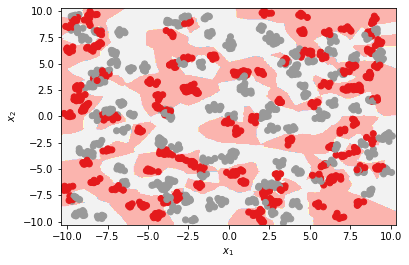

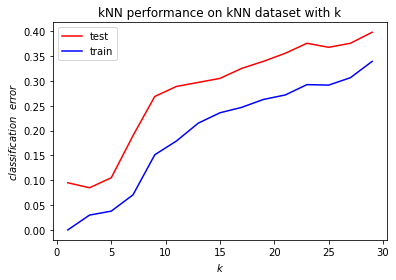

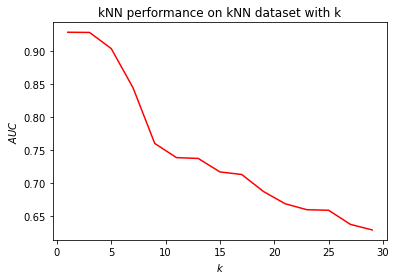

In [25]:
# kNN

knn = kNC(n_neighbors=k_nn)

print('kNN on kNN Dataset:')
test_model(knn, nn_X, nn_y)

# knn.fit(nn_X_train, nn_y_train)
# print('kNN score: %.2f' % (knn.score(nn_X_test, nn_y_test)))
# plot_classifier_boundary(knn, nn_X, nn_y, title='kNN on kNN dataset')

# Hyperparameter testing
errors = map(lambda k: knn_classifier_err(k, nn_X_train, nn_y_train, nn_X_test, nn_y_test), k_values)
plot_test_training_err(k_values, errors, title='kNN performance on kNN dataset with k', hyperparam='k')

aucs = map(lambda k: knn_classifier_auc(k, nn_X, nn_y), k_values)
plot_test_training_auc(k_values, aucs, title='kNN performance on kNN dataset with k', hyperparam='k')



Decision Trees on kNN Dataset:
AUC score: 0.841
AUC score list: [0.8262786596119929, 0.8363453815261044, 0.8424725741151887, 0.8404838867665786, 0.8464721823168343, 0.8649908562471427, 0.8525368943450438, 0.8461386399578281, 0.8365161564348024, 0.818204081632653]


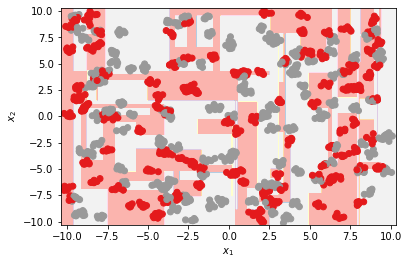

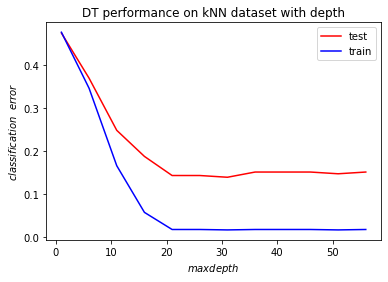

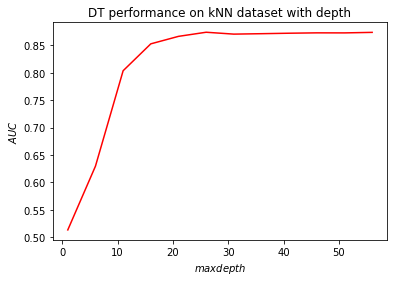

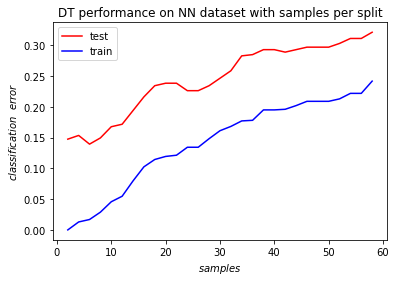

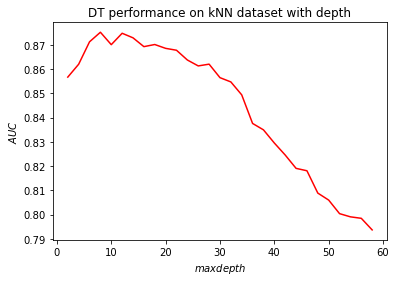

In [26]:
# Decision Trees

dtree=DTC(criterion=criterion, max_depth=max_depth_nn, min_samples_split=min_samples_split_nn)

print('Decision Trees on kNN Dataset:')
test_model(dtree, nn_X, nn_y)

# dtree.fit(nn_X_train, nn_y_train)
# print('DT score: %.2f' % (dtree.score(nn_X_test, nn_y_test)))
# plot_classifier_boundary(dtree, nn_X, nn_y, title='DT on kNN dataset')
# plot_tree(dtree)

# DT Hyperparam Tuning
errors = map(lambda depth: dt_classifier_score(
    nn_X_train, nn_y_train, 
    nn_X_test, nn_y_test, 
    max_depth=depth,
    min_samples_split=min_samples_split_nn), ndepth)
plot_test_training_err(ndepth, errors, title='DT performance on kNN dataset with depth', hyperparam='max depth')

aucs = map(lambda depth: dt_classifier_auc(nn_X, nn_y, max_depth=depth, min_samples_split=min_samples_split_nn), ndepth)
plot_test_training_auc(ndepth, aucs, title='DT performance on kNN dataset with depth', hyperparam='max depth')

errors = map(lambda sample: dt_classifier_score(
    nn_X_train, nn_y_train, 
    nn_X_test, nn_y_test, 
    max_depth=max_depth_nn, 
    min_samples_split=sample), nsamples)
plot_test_training_err(nsamples, errors, title='DT performance on NN dataset with samples per split', hyperparam='samples')

aucs = map(lambda sample: dt_classifier_auc(nn_X, nn_y, max_depth=max_depth_nn, min_samples_split=sample), nsamples)
plot_test_training_auc(nsamples, aucs, title='DT performance on kNN dataset with samples per split', hyperparam='samples')


## Dataset DT ##

### Compare Performance of kNN and DT ### 

Test kNN on DT Dataset:
AUC score: 0.787
AUC score list: [0.757532281205165, 0.84391771019678, 0.838855421686747, 0.7445378151260504, 0.6946536144578314, 0.8398026315789474, 0.8112701252236135, 0.845798319327731, 0.7130952380952381, 0.7761904761904761]


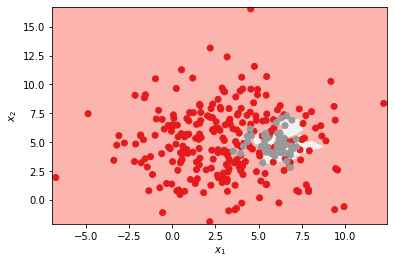

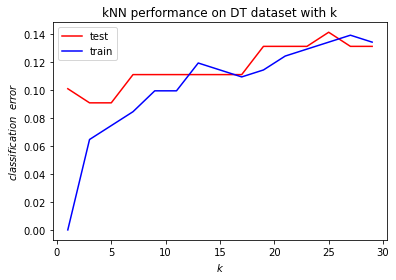

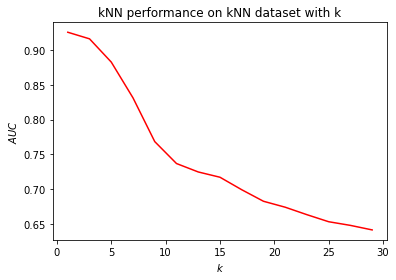

In [27]:
# kNN
knn = kNC(n_neighbors=k_dt)

print('Test kNN on DT Dataset:')
test_model(knn, dt_X, dt_y)

# knn.fit(dt_X_train, dt_y_train)
# print('kNN score: %.2f' % (knn.score(dt_X_test, dt_y_test)))
# plot_classifier_boundary(knn, dt_X, dt_y, title='kNN on DT dataset')

# hyperparameter testing
errors = map(lambda k: knn_classifier_err(k, dt_X_train, dt_y_train, dt_X_test, dt_y_test), k_values)
plot_test_training_err(k_values, errors, title='kNN performance on DT dataset with k', hyperparam='k')

aucs = map(lambda k: knn_classifier_auc(k, nn_X, nn_y), k_values)
plot_test_training_auc(k_values, aucs, title='kNN performance on kNN dataset with k', hyperparam='k')


Decision Trees on DT Dataset:
AUC score: 0.781
AUC score list: [0.8052367288378766, 0.8690817790530847, 0.8689759036144578, 0.6623563218390806, 0.7118421052631578, 0.8950617283950617, 0.7865546218487396, 0.7330572289156627, 0.8051948051948051, 0.6690518783542039]


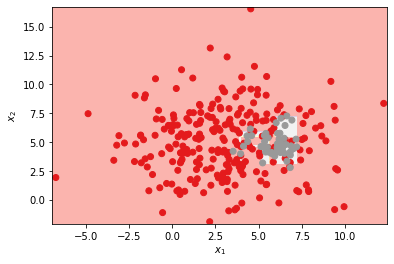

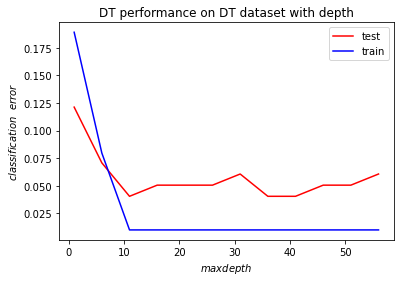

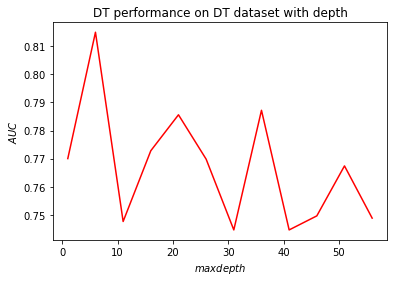

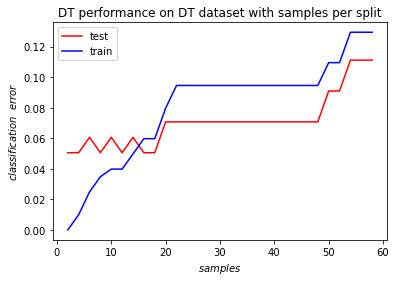

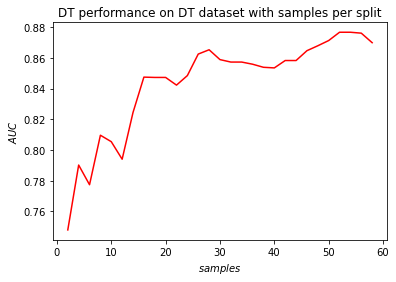

In [28]:
# Decision Trees
# add cross validation to find right hyperparameters

dtree=DTC(criterion='entropy', max_depth=max_depth_dt, min_samples_split=min_samples_split_dt)

print('Decision Trees on DT Dataset:')
test_model(dtree, dt_X, dt_y)

# dtree.fit(dt_X_train, dt_y_train)
# print('DT score: %.2f' % (dtree.score(dt_X_test, dt_y_test)))
# plot_classifier_boundary(dtree, dt_X, dt_y, title='DT on DT dataset')
# plot_tree(dtree)

# hyperparameter tuning
# max depth
errors = map(lambda depth: dt_classifier_score(
    dt_X_train, dt_y_train, 
    dt_X_test, dt_y_test, 
    max_depth=depth,
    min_samples_split=min_samples_split_dt), ndepth)

plot_test_training_err(ndepth, errors, title='DT performance on DT dataset with depth', hyperparam='max depth')

aucs = map(lambda depth: dt_classifier_auc(dt_X, dt_y, max_depth=depth, min_samples_split=min_samples_split_dt), ndepth)
plot_test_training_auc(ndepth, aucs, title='DT performance on DT dataset with depth', hyperparam='max depth')

# min samples per split
errors = map(lambda sample: dt_classifier_score(
    dt_X_train, dt_y_train, 
    dt_X_test, dt_y_test,
    max_depth=max_depth_dt,
    min_samples_split=sample), nsamples)

plot_test_training_err(nsamples, errors, title='DT performance on DT dataset with samples per split', hyperparam='samples')

aucs = map(lambda sample: dt_classifier_auc(dt_X, dt_y, max_depth=max_depth_dt, min_samples_split=sample), nsamples)
plot_test_training_auc(nsamples, aucs, title='DT performance on DT dataset with samples per split', hyperparam='samples')
